In [1]:
import os
os.chdir("../")
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.factory.config_factory import cfg, show_configs, build_output
from src.factory.data_factory import DataFactory
from src.factory.data_format_factory import DataFormatFactory
from src.factory.transform_factory import TransformFactory
from src.factory.loader_factory import LoaderFactory
from src.base_data import BaseData
from tools.logger import setup_logger
from tqdm import tqdm
logger = setup_logger("./external/")

In [2]:
cfg.merge_from_file("./configs/person.yml")
# build_output(cfg, "./configs/person.yml")

In [2]:
cfg.NUM_WORKERS = 1
cfg.DB.PATH = "/media/allen/mass/DB"
cfg.DB.DATA = "prw ethz coco"
cfg.DB.DATA_FORMAT = "coco"
cfg.DB.TARGET_FORMAT = "centernet"
cfg.DB.LOADER = "coco"
cfg.DB.USE_TRAIN = True
cfg.DB.USE_TEST = False
cfg.INPUT.SIZE = (512, 512)
cfg.INPUT.TRAIN_BS = 1
cfg.MODEL.STRIDES = [4]
cfg.DB.TRAIN_TRANSFORM = "RandScale Tensorize"
cfg.DB.TEST_TRANSFORM = "Resize Tensorize"
cfg.COCO.TARGET = "person"


In [3]:
loader = LoaderFactory.produce(cfg)
branch = 'val'

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
2020-04-16 21:07:14,852 21053 coco.py INFO: => CITYPERSON VAL is loaded
2020-04-16 21:07:14,853 21053 coco.py INFO:   Dataset statistics:
2020-04-16 21:07:14,853 21053 coco.py INFO:   -----------------------------
2020-04-16 21:07:14,854 21053 coco.py INFO:   subset   | #id     | # images
2020-04-16 21:07:14,855 21053 coco.py INFO:   -----------------------------
2020-04-16 21:07:14,858 21053 coco.py INFO:   val    |       0 |      733
2020-04-16 21:07:14,859 21053 coco.py INFO:   -----------------------------


In [9]:
import pycocotools.coco as coco
import json
import os
import os.path as osp
from PIL import Image
from tqdm import tqdm
import numpy as np
import shutil
import cv2
from pycocotools.cocoeval import COCOeval
from tools.centernet_utils import centernet_det_decode, centernet_det_post_process
from tools.oracle_utils import gen_oracle_map
from tools.image import get_affine_transform
from copy import deepcopy

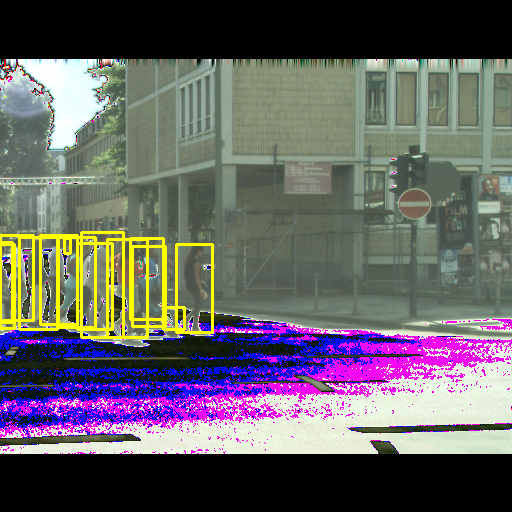

In [41]:
batch = next(iter(loader[branch]))
batch['bboxes']
bboxes = np.vstack(batch['bboxes'])
bboxes[:, [0,2]] *= 512
bboxes[:, [1,3]] *= 512
np_img = (batch['inp']*255).squeeze().permute(1,2,0).numpy().astype(np.uint8)
np_img = cv2.resize(np_img, (512,512))
Image.fromarray(np_img)
for b in bboxes:
    x1, y1, x2, y2 = b
    cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), 2)
Image.fromarray(np_img)

In [5]:
def _to_float(x):
    return float("{:.2f}".format(x))
    
def convert_eval_format(all_bboxes, valid_ids):
    # import pdb; pdb.set_trace()
    detections = []
    for image_id in all_bboxes:
        for cls_ind in all_bboxes[image_id]:
            for bbox in all_bboxes[image_id][cls_ind]:
                bbox[2] -= bbox[0]
                bbox[3] -= bbox[1]
                score = bbox[4]
                bbox_out  = list(map(_to_float, bbox[0:4]))
                category_id = valid_ids[cls_ind - 1]
                detection = {
                    "image_id": int(image_id),
                    "category_id": int(category_id),
                    "bbox": bbox_out,
                    "score": float("{:.2f}".format(score))
                }
                detections.append(detection)
    return detections

In [11]:
results = {}
normalized_detection = []
for batch in tqdm(loader[branch]):
    # bbox = batch['bboxes'][0]
    # w, h = batch['c'][0]*2
    # bbox[:,[0,2]] *= w
    # bbox[:,[1,3]] *= h
    # normalized_detection.append((bbox.numpy()))
    dets = (batch['bboxes'][0]*128).numpy()
    meta = np.zeros((dets.shape[0],2))
    meta[:,0] = 1
    dets = np.concatenate([dets, meta], axis=1)[np.newaxis, :]
    dets_out = centernet_det_post_process(
        dets=dets.copy(), 
        c=batch['c'].numpy(), 
        s=batch['s'].numpy(), 
        h=128, 
        w=128, 
        num_classes=1
    )
    results[batch['img_id'][0].item()] = dets_out[0]

100%|██████████| 733/733 [00:40<00:00, 18.11it/s]


In [12]:
handle = loader[branch].dataset.coco[0]
orig_detections = convert_eval_format(results, handle.getCatIds())
json.dump(orig_detections, open('./external/orig_results.json', 'w'))
coco_dets = handle.loadRes('./external/orig_results.json')
coco_eval = COCOeval(handle, coco_dets, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.30s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.972
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.965
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.955
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.988
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [138]:
orig_detections[0]

{'image_id': 1,
 'category_id': 1,
 'bbox': [947.0, 406.0, -930.0, -366.0],
 'score': 1.0}

In [139]:
for orig_b, b in zip(orig_detections, detections):
    diff = np.array(orig_b['bbox']) - np.array(b['bbox'])
    print(diff)
    if diff.sum() > 0:
        print(orig_b)
        print(b)
    

412.]
[   0.    0. -406. -405.]
[   0.    0. -397. -414.]
[   0.    0. -354. -399.]
[   0.    0. -185. -410.]
[   0.    0. -186. -394.]
[   0.    0.  -53. -359.]
[   0.    0. -258. -431.]
[   0.    0. -374. -391.]
[   0.    0. -261. -402.]
[   0.    0. -448. -376.]
[   0.    0. -504. -384.]
[   0.    0. -595. -353.]
[   0.    0.  -84. -451.]
[   0.    0.  -33. -452.]
[   0.    0.   -3. -446.]
[   0.    0.  -26. -446.]
[   0.    0.  -57. -446.]
[   0.    0.  -72. -443.]
[   0.    0. -153. -355.]
[   0.    0. -345. -387.]
[   0.    0. -785. -389.]
[   0.    0. -840. -392.]
[   0.    0. -799. -392.]
[   0.    0. -112. -402.]
[   0.    0.  -96. -414.]
[   0.    0. -216. -395.]
[   0.    0. -878. -450.]
[   0.    0. -329. -432.]
[   0.    0. -505. -433.]
[   0.    0. -161. -431.]
[   0.    0. -410. -407.]
[   0.    0. -342. -414.]
[   0.    0. -308. -400.]
[   0.    0. -853. -393.]
[   0.    0.  -23. -414.]
[   0.    0.  -31. -413.]
[   0.    0.  -94. -404.]
[   0.    0. -526. -353.]
[   0.

In [134]:
diff

array([0., 0., 0., 0.])

In [45]:
img_id = batch['img_id'][0].item()
handle = loader[branch].dataset.coco[0]
fname = handle.loadImgs(ids=[img_id])[0]['file_name']
fname = os.path.join(cfg.DB.PATH, "cityperson", "val2017", fname)
fname

'/media/allen/mass/DB/cityperson/val2017/frankfurt/frankfurt_000001_057954_leftImg8bit_right.png'

14


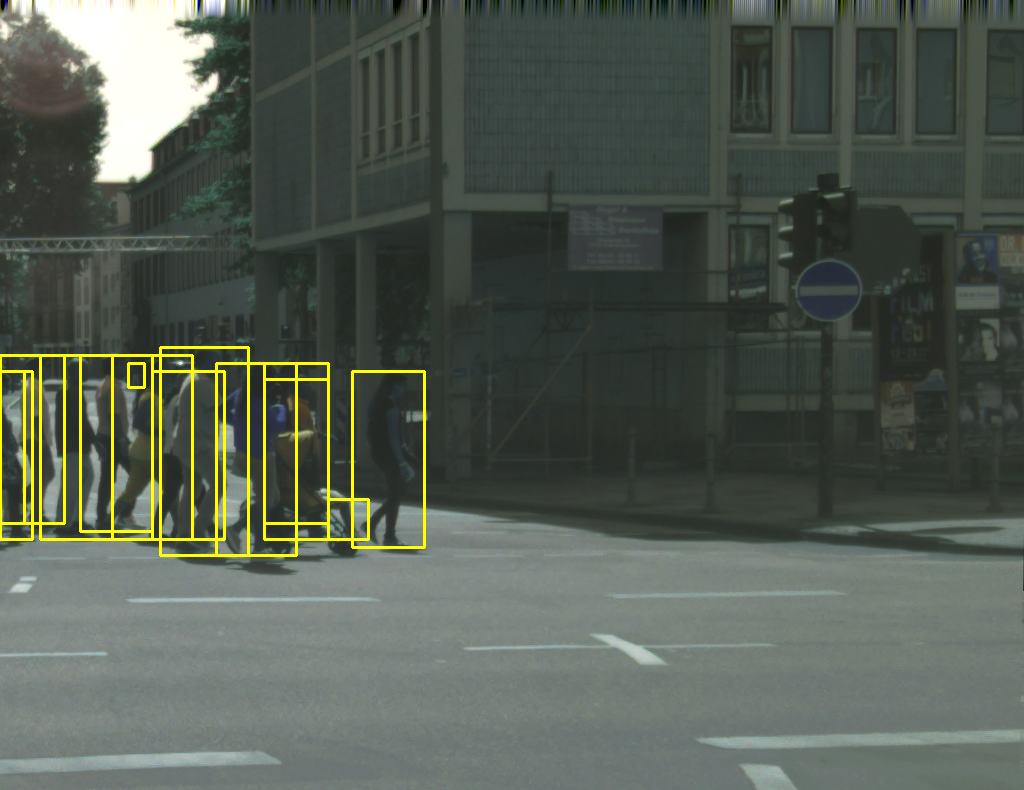

In [51]:
# np_img = (batch['inp']*255).squeeze().permute(1,2,0).numpy().astype(np.uint8)
np_img = cv2.imread(fname)
num = 0
for c in final[0]:
    for b in final[0][c]:
        x1, y1, x2, y2, score = b
        if score > 0.5:
            num += 1
            cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), 2)
pil_img = Image.fromarray(np_img)
w, h = pil_img.size
print(num)
pil_img

In [52]:
def _coco_box_to_bbox(box):
    bbox = np.array([box[0], box[1], box[0] + box[2], box[1] + box[3]], dtype=np.float32)
    return bbox
ann_ids = handle.getAnnIds(imgIds=[img_id])
anns = handle.loadAnns(ids=ann_ids)
num_objs = len(anns)
src_bboxes = []
for k in range(num_objs):
    ann = anns[k]
    src_bboxes.append(_coco_box_to_bbox(ann['bbox']))

14

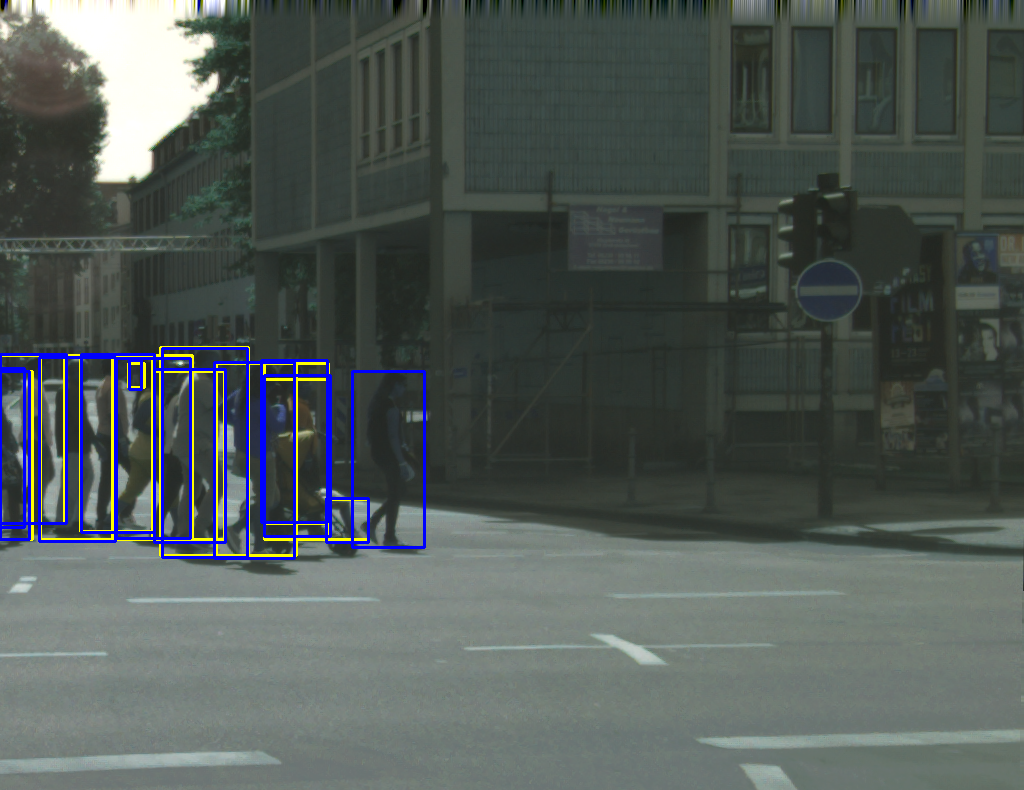

In [50]:
# np_img = cv2.imread(fname)
for b in src_bboxes:
    x1, y1, x2, y2 = b
    cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
Image.fromarray(np_img)

In [19]:
pil_img.size

(640, 427)

In [73]:
src = f"/media/allen/mass/deep-learning-works/evaluation/caltech cityperson cityperson/Hourglass-coco_cityperson_caltech-person-focal_l1-SGDW_cosine_lr_0.01_warmup-scratch/000-2020-04-16_10-03/results.json"
f = open(src, 'r')
results = json.load(f)

In [75]:
final = []
for result in results:
    if result['score'] > 0.5:
        final.append(result)

In [79]:
len(result)

4

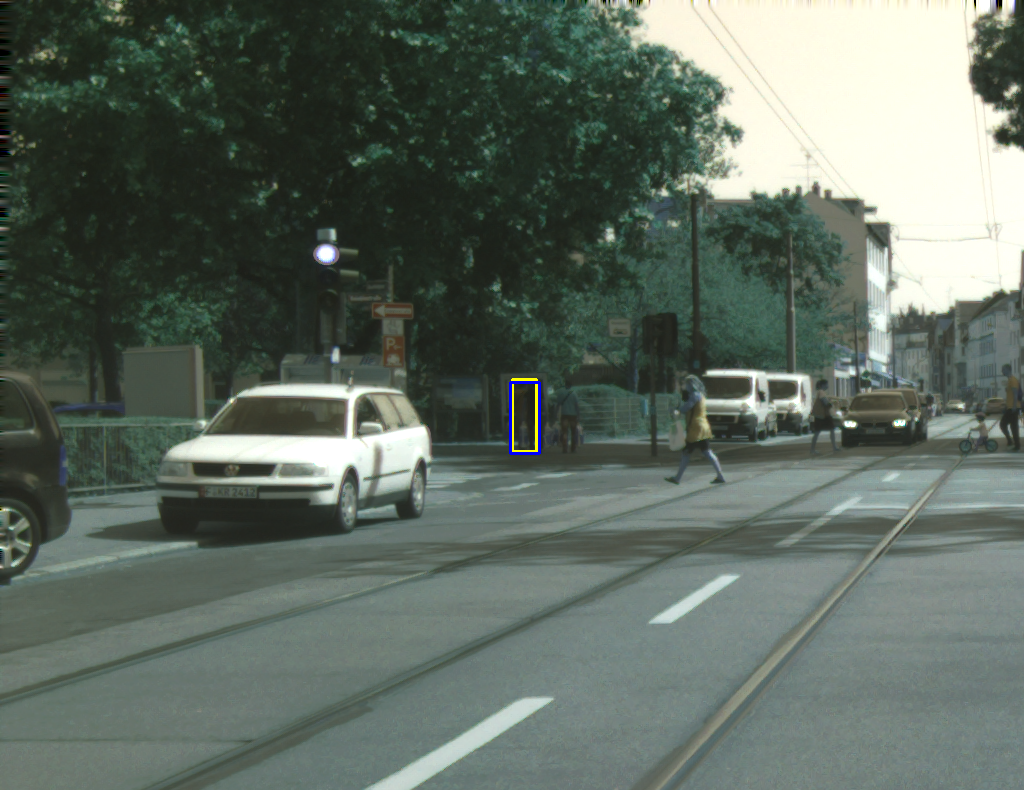

In [104]:
idx = 10
img_id = final[idx]['image_id']
handle = loader[branch].dataset.coco[0]
fname = handle.loadImgs(ids=[img_id])[0]['file_name']
fname = os.path.join(cfg.DB.PATH, "cityperson", "val2017", fname)
np_img = cv2.imread(fname)
x1, y1, w, h = final[idx]['bbox']
cv2.rectangle(np_img, (int(x1), int(y1)), (int(x1+w), int(y1+h)), (255,255,0), 2)
x1, y1, w, h = detections[idx+3]['bbox']
cv2.rectangle(np_img, (int(x1), int(y1)), (int(x1+w), int(y1+h)), (0,0,255), 2)
Image.fromarray(np_img)

In [12]:
handle = loader[branch].dataset.coco[0]
image_ids = handle.getImgIds()
detections = []
for img_id in image_ids:
    ann_ids = handle.getAnnIds(imgIds=[img_id])
    anns = handle.loadAnns(ids=ann_ids)
    for ann in anns:
        detection = {
            "image_id": int(img_id),
            "category_id": int(ann['category_id']),
            "bbox": ann['bbox'],
            "score": 1.0,
            'id': int(ann['id'])
        }
        detections.append(detection)
    # breakhandle = loader[branch].dataset.coco[0]
# json.dump(detections, open('./external/results.json', 'w'))
# coco_dets = handle.loadRes('./external/results.json')
# coco_eval = COCOeval(handle, coco_dets, "bbox")
# coco_eval.evaluate()
# coco_eval.accumulate()
# coco_eval.summarize()


In [15]:
len(orig_detections)

4251

In [16]:
handle = loader[branch].dataset.coco[0]
json.dump(detections, open('./external/results.json', 'w'))
coco_dets = handle.loadRes('./external/results.json')
coco_eval = COCOeval(handle, coco_dets, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.26s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.172
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10